# Memology - DataScience & Memes
![](http://orig07.deviantart.net/3e62/f/2015/267/4/1/meme_team_logo_png_smol_by_kuiwi-d9ass0h.png)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import json

from sklearn.learning_curve import validation_curve,learning_curve
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

import seaborn as sn
from pylab import rcParams      
rcParams['figure.figsize'] = 8, 8
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

/Users/dmitrys/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/dmitrys/anaconda2/lib/python2.7/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

###  Часть 1. Описание набора данных и признаков

**Пара слов о проекте**

С сайта [knowyourmeme.com](http://knowyourmeme.com/) по состоянию на 10 ноября 2016 года я спарсил все 11679 мемов, заботливо разложенных на 369 страницах. Переход на каждую страницу в автоматическом режиме грозил мне блокировкой IP адреса. Чтобы этого не происходило, пришлось долго и упорно искать способы обхода блокировки, результатом которых стал TOR, динамически обновляющий IP практически после каждого запроса, к которому удалось подключится в питоне. Подробнее про парсер можно узнать в [репозитории](https://github.com/DmitrySerg/memology). 

Собствено, проект посвящен исследованию этих веселых картинок на предмет предсказания их популярности на основании описания

In [3]:
memes = pd.read_csv('/Users/dmitrys/Desktop/DataProjects/KnowYourMemes/all_data_memes.csv')

In [4]:
memes.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)

In [5]:
memes = memes.drop_duplicates("name") # из-за структуры сайта, некоторые мемы добавлялись неоднократно

In [6]:
memes.reset_index(drop=True, inplace=True)

In [7]:
memes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11679 entries, 0 to 11678
Data columns (total 10 columns):
name        11679 non-null object
added       11679 non-null object
views       11679 non-null int64
comments    11679 non-null object
status      11679 non-null object
year        11679 non-null object
tags        11679 non-null object
about       6832 non-null object
origin      4819 non-null object
spread      947 non-null object
dtypes: int64(1), object(9)
memory usage: 912.5+ KB


Итак, пройдемся по переменным:

- name - название мема
- added - дата добавления
- views - число просмотров на сайте
- comments - число комментариев
- status - категориальная переменная, статус присваивается на сайте в зависимости от "одобрения" мема сообществом
- year - год, к которому относится первоисточник появления картинки (например, год выхода определенной серии Симпсонов)
- tags - тэги, также являются категориями
- about - описание мема
- origin - описание происхождения
- spread - где приобрел особенную популярность

In [8]:
memes.head(3)

,name,added,views,comments,status,year,tags,about,origin,spread
0,Last Time The Cubs Won the World Series,"Nov 03, 2016 at 11:22AM EDT",17157,60,Submission,Sports,Chicago,Last Time the Cubs Won the World Series refers...,NaN,Jokes and fascination with the Cubs’ had small...
1,PenorCut's Fiverr Videos,"Jul 20, 2015 at 07:54PM EDT",36629,39,Submission,Researching,YouTube,NaN,NaN,NaN
2,AmourShipping,"Nov 02, 2016 at 03:01PM EDT",32293,81,Submission,Pairing,Unknown,Amourshipping refers to the romantic pairing o...,"On September 12th, 2013, a discussion thread f...",NaN


In [9]:
memes.tail(3)

,name,added,views,comments,status,year,tags,about,origin,spread
11676,Cannon Penis,"Oct 11, 2010 at 06:07PM EDT",20202,14,Submission,NSFW,YouTube,NaN,NaN,NaN
11677,Gaben,"Oct 11, 2010 at 01:22PM EDT",479780,49,Submission,2010,"tf2, stop, newell, control, wait, gabe, gaben,...","Gaben is a nickname given to Gabe Newell, the ...",The soundclip of Gabe Newell saying “gaben” ca...,NaN
11678,alex smith fail,"Oct 11, 2010 at 06:00AM EDT",2730,14,Deadpool,2010,"alex smith, 49ers, sf, san francisco, fail.qb,...",NaN,NaN,NaN


###  Часть 2. Первичный анализ признаков

Конечно же, в первую очередь хочется посмотреть на самый популярный в мире мем

In [10]:
memes[memes.views==memes.views.max()]

,name,added,views,comments,status,year,tags,about,origin,spread
5408,Doge,"Jul 24, 2013 at 04:29PM EDT",11551088,893,Confirmed,Character,Tumblr,Doge is a slang term for “dog” that is primari...,The use of the misspelled word “doge” to refer...,"On October 28th, 2010, a photo of Kabosu was s..."


И это Доге!

![](http://i2.kym-cdn.com/entries/icons/original/000/013/564/aP2dv.gif)

# Время добавления

Так как в нашем распоряжении есть чудесная переменная `added`, то можно поиграться с ней, преобразовав в понятный питону формат и повытаскивая из него час, день недели и месяца, месяц и год добавления

In [11]:
memes['Timestamp'] = memes.added.apply(lambda x: pd.to_datetime(x))
memes['Year'] = memes.Timestamp.apply(lambda x: x.year)
memes['Month'] = memes.Timestamp.apply(lambda x: x.month)
memes['Day'] = memes.Timestamp.apply(lambda x: x.day)
memes['Hour'] = memes.Timestamp.apply(lambda x: x.hour)
memes['Weekday'] = memes.Timestamp.apply(lambda x: x.weekday())

Также пригодится переменная, отвечающая за число дней, прошедших с момента добавления мема на сайт

In [12]:
memes['days_from_creation'] = (memes.Timestamp.max() - memes.Timestamp)/np.timedelta64(1, 'D')

А теперь для наших созданных переменных построим несколько гистограмм

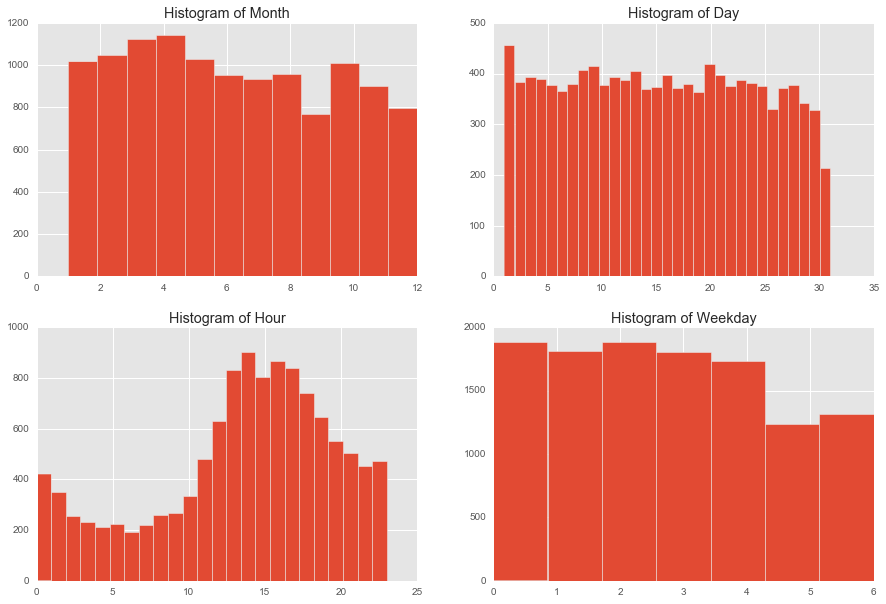

In [13]:
index =0 
f, axarr = plt.subplots(2, 2, figsize=(15,10))
times = ['Month', 'Day', 'Hour', 'Weekday']
bins = [12, 31, 24, 7]
index = 0
for i in range(2):
    for j in range(2):
        axarr[i, j].hist(memes[times[index]], bins = bins[index])
        axarr[i, j].set_title('Histogram of {}'.format(times[index]))
        index += 1

f.subplots_adjust(hspace=0.2)

Итак, что тут есть интересного:
- На гистограмме месяца есть небольшой провал в сентябре (возможно, у основной аудитории в этот месяц начинаются уроки)
- День ничего необычного не принес, распределено достаточно равномерно
- Гистограмма часа достаточно показательная - в ночной период активность значительно снижается, а затем растет, достигая пика примерно после уроков
- По дням недели есть заметное снижения на выходных, интересно, почему бы это

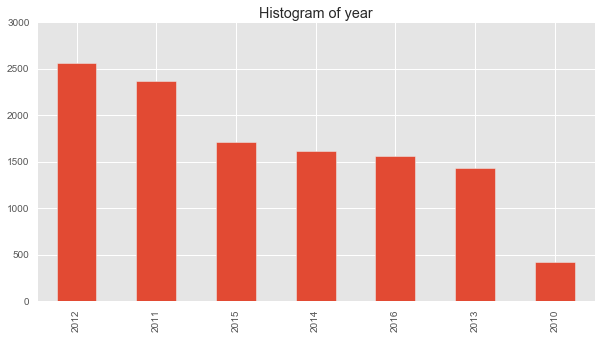

In [14]:
memes.Year.value_counts().plot(kind='bar', figsize=(10, 5))
plt.title("Histogram of year")
plt.show()

In [15]:
memes.Year.value_counts(normalize=True).apply(lambda x: "{}%".format(str(round(x, 3)*100)))

2012    21.9%
2011    20.3%
2015    14.7%
2014    13.9%
2016    13.4%
2013    12.3%
2010     3.6%
Name: Year, dtype: object

Похоже, 2011 и 2012 были расцветом для мемов, 42% от всего их количества на сайте были добавлены в эти два года.

# Год появления первоисточника

Посмотрим также на вторую переменную, связанную с годом - год появления первоисточника `year`

In [16]:
memes.year.value_counts()[:10]

2011           1670
2012           1238
Unknown         881
2010            597
2013            581
NSFW            541
2014            529
2016            406
Researching     383
2015            343
Name: year, dtype: int64

К сожалению, сюда затесалось несколько тэгов, придется очистить переменную от них, попутно добавив эти значения в переменную `tags`

In [17]:
def clearYear(year):
    if not year.isdigit():
        return np.NaN, ' '+year
    else:
        return int(year), ''

In [18]:
years, tags = zip(*memes.year.apply(lambda x: clearYear(x)))
memes.year = years
memes.tags += tags

In [19]:
memes.tags[memes.tags.isin(['none...', 'none', 'Unknown', 'none... Unknown', 'None'])] = 'unknown'

In [20]:
memes.year.describe()

count    7218.000000
mean     2007.279163
std        40.585179
min      1000.000000
25%      2009.000000
50%      2011.000000
75%      2013.000000
max      2916.000000
Name: year, dtype: float64

Отлично! Теперь переменная очищена от текстовых значений, минимальное значение у нас 1000, максимальное - 2196, что очень похоже на опечатку в "2016"

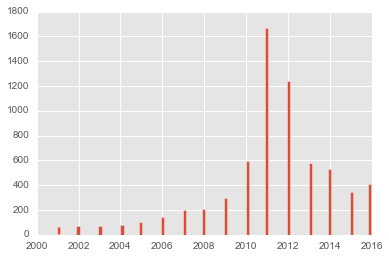

In [21]:
memes.year[(memes.year>2000)&(memes.year<2020)].hist(bins=100)
plt.show()

Немного ограничив временные рамки можно выяснить, что 2011 и 2012 стали первоисточниками для наибольшего числа мемов

Можем посмотреть на наиболее "исторические" мемы, берущие своё начало, например, до 1500 года

In [22]:
ancient = memes[memes.year<1500]
for i in ancient.index.tolist():
    print("Name: {}".format(ancient.loc[i, "name"]))
    print("Year: {}".format(ancient.loc[i, "year"]))
    print("About:\n{}".format(ancient.loc[i, "about"]))
    print("==================================================================\n")

Name: Tutankhamun
Year: 1341.0
About:
Tutankhamun (lit. translation, Living Image of Amun) was an ancient Egyptian pharaoh who rose to power and control of Egypt at the age of 10 and ruled for approximately 8 years before his death in 1323 B.C. at the age of 18 or 19 years old. Because of this, as well as the circumstances surrounding the excavation of his tomb lead by Howard Carter in 1922, and what has been discovered since his tomb’s discovery, he has become famous around the world for being the subject of one of the world’s most in-depth excavations and ongoing archaeological mysteries.

Name: Foxes
Year: 1000.0
About:
Foxes are omnivorous members of the Canidae family, a lineage of carnivorous mammals that also includes dogs, wolves and jackals. Foxes are found on every continent except Antarctica, with the most common species being the red fox (Vulpes vulpes) and its 47 recognized sub-species.

Name: Katana
Year: 1392.0
About:
Katana are traditional Japanese swords originally wie

К сожалению, не у всех есть описание, но в целом понятно, откуда взялись такие древние годы происхождения - создание первой катаны в Японии, битва при Гастингсе в 1066 году, Витрувианский человек и Последняя вечеря Леонардо да Винчи 1490 и 1495 годы соответственно. Откуда только не черпают вдохновение создатели мемчиков

# Число просмотров

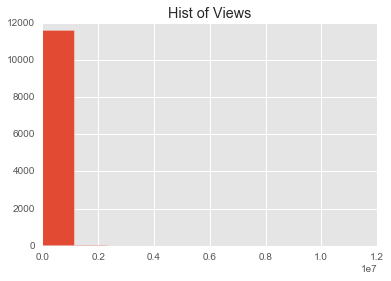

In [23]:
memes.views[memes.views>0].hist(bins=10)
plt.title("Hist of Views")
plt.show()

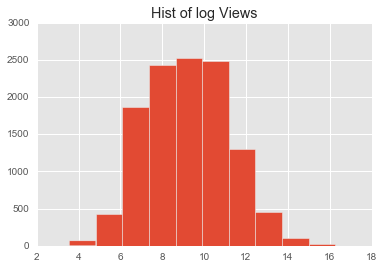

In [24]:
memes.views[memes.views>0].apply(np.log).hist(bins=10)
plt.title("Hist of log Views")
plt.show()

# Популярность

Метрикой популярности, в данном случае, будет оценка среднего числа просмотров в день. Для этого разделим фактическое число просмотров на число дней, прошедших со дня публикации.

In [25]:
memes['average_views'] = memes.views/memes.days_from_creation

In [26]:
memes.average_views[memes.name=="#DrunkHillary"] = 2568 # самый молодой мем, на момент выгрузки дней с его создания прошло ровно 0,
                                                        # поэтому присваиваем среднему число просмотров фактическое

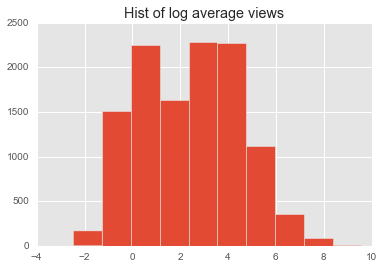

In [27]:
plt.hist(memes.average_views.apply(np.log))
plt.title("Hist of log average views");

### Посмотрим на самые популярные!

In [28]:
popular = memes.sort_values(by='average_views', ascending=False)
for i in popular.index.tolist()[:7]:
    print('Meme name: ')
    print(popular.loc[i,'name'])
    print("Average views (per day) {}".format(round(popular.loc[i,'average_views'])))
    print('==============\n')

Meme name: 
Harambe the Gorilla
Average views (per day) 14441.0

Meme name: 
Dat Boi
Average views (per day) 13750.0

Meme name: 
Ken Bone
Average views (per day) 11085.0

Meme name: 
Doge
Average views (per day) 9611.0

Meme name: 
Describe Yourself in 3 Fictional Characters
Average views (per day) 7528.0

Meme name: 
Hugh Mungus
Average views (per day) 6872.0

Meme name: 
( ͡° ͜ʖ ͡°) / Lenny Face
Average views (per day) 6747.0



Горила [Harambe](http://knowyourmeme.com/memes/harambe-the-gorilla) лидирует - слишком эмоциональный мем получился. Хотя Doge тоже есть в числе лидеров!

# Комментарии

In [29]:
memes.comments[~memes.comments.apply(lambda x: x.isdigit())][:10]

9      1 Comment">\n<a href="/memes/sombra#comments" ...
10     1 Comment">\n<a href="/memes/subcultures/pokem...
36     1 Comment">\n<a href="/memes/cajama#comments" ...
56     1 Comment">\n<a href="/memes/spinnyboiz#commen...
65     1 Comment">\n<a href="/memes/finally-i-can-exp...
71     1 Comment">\n<a href="/memes/mr-hudson#comment...
117    1 Comment">\n<a href="/memes/wallace-and-gromi...
118    1 Comment">\n<a href="/memes/worm-on-a-string#...
120    1 Comment">\n<a href="/memes/slondermon#commen...
122    1 Comment">\n<a href="/memes/harambe-s-son-and...
Name: comments, dtype: object

Снова придется немного почистить - в комментарии закрался HTML

In [30]:
memes.comments[~memes.comments.apply(lambda x: x.isdigit())] = 1
memes.comments = memes.comments.astype(int)

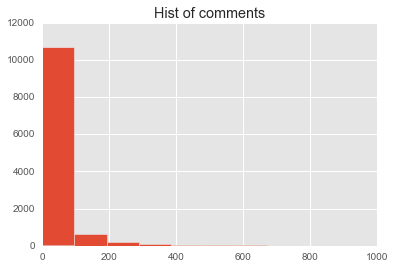

In [31]:
memes.comments.hist()
plt.title("Hist of comments")
plt.show()

### Посмотрим на самые комментируемые

In [32]:
memes['average_comments'] = memes.comments/memes.days_from_creation

In [33]:
memes.average_comments[memes.name == "#DrunkHillary"] = memes.comments[memes.name == "#DrunkHillary"]

In [34]:
popular = memes.sort_values(by='average_comments', ascending=False)
for i in popular.index.tolist()[:7]:
    print('Meme name: ')
    print(popular.loc[i,'name'])
    print("Average comments (per day) {}".format(round(popular.loc[i,'average_comments'])))
    print('==============\n')

Meme name: 
#SpiritCooking
Average comments (per day) 50.0

Meme name: 
#DrunkHillary
Average comments (per day) 29.0

Meme name: 
AmourShipping
Average comments (per day) 16.0

Meme name: 
#ScienceMustFall
Average comments (per day) 16.0

Meme name: 
Last Time The Cubs Won the World Series
Average comments (per day) 15.0

Meme name: 
Vote From Home
Average comments (per day) 14.0

Meme name: 
"On November 9th..."
Average comments (per day) 12.0



# Статус

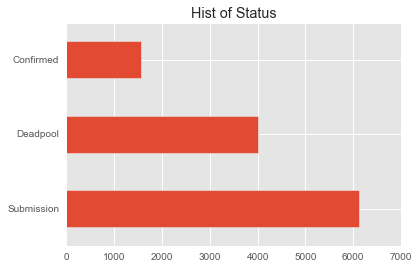

In [35]:
memes.status.value_counts().plot(kind='barh')
plt.title("Hist of Status")
plt.show()

А вот здесь можно попутно решить еще и задачку множественной классификации - для каждого мема есть три состояния:
- Submission - добавлен недавно или не еще не стал "признанным" в сообществе
- Deadpool - если умер и не используется
- Confirmed - активно используется и получил статус "подтвержденного" мема

---



# ML

In [36]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import RussianStemmer

In [37]:
stop = stopwords.words('english')
stemmer = nltk.stem.snowball.EnglishStemmer('english')

def data_Stemmer(text):
    return ' '.join([stemmer.stem(word) for word in text.split(' ')])

In [38]:
memes["description"] = memes.tags.fillna('')+' '+memes.about.fillna("")+' '+memes.origin.fillna("")+ " " + memes.spread.fillna("")

In [39]:
memes.description = memes.description.apply(lambda x: x.lower().replace('unknown', ''))

In [40]:
from __future__ import division

In [41]:
X = memes.description[memes.description!="   "]
y = memes.average_views[memes.description!="   "]
status = memes.status[memes.description!="   "]

In [42]:
status = le.fit_transform(status)

Для TF-IDF попробуем использовать биграммы, а чтобы словарь не раздувался до неадекватных размеров, ограничим минимальную частоты содержания слов в документах 0.1%. То есть будем выкидывать такие слова и биграммы, которые встречаются реже, чем в 0.1% документов. Это позволит сократить размерность с 363K до 6.4K слов

In [43]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
tf_vectorizer = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2), min_df=0.001, norm='l2')

In [44]:
X_train_vector = tf_vectorizer.fit_transform(X)
X_train_vector.shape

(11154, 6456)

30% выборки отложим для тестирования

In [45]:
Xtr, Xval, ytr, yval  = train_test_split(X_train_vector, y, test_size=0.30, random_state=42)

Целевую переменную (среднее число просмотров в день), разделим на пять групп по квантилям, одновременно получая наивный baseline - если мы всем объектам примишем один класс, то итоговая точность составит 1/5 = 20%. Еще один плюс подхода - дисбаланса классов у нас точно не будет :)

In [46]:
ytr = pd.qcut(ytr, q=5)

In [47]:
ytr.value_counts()

(76.442, 11084.963]    1562
[0.085, 1.518]         1562
(25.185, 76.442]       1561
(6.795, 25.185]        1561
(1.518, 6.795]         1561
Name: average_views, dtype: int64

Что ж, получились неплохие группы:
- совсем мертвые - если просмотров меньше 1 в день
- непопулярные - если от 1 до 6 просмотров 
- средние - от 6 до 24 просмотров
- популярные - от 24 до 74 
- супер популярные (виральные) - выше 74 просмотров в день

Для будущих нужд запомним имеющиеся интервалы

In [48]:
intervals = ytr.unique().categories.get_values()

Так как на тестовой выборке мы аналогичное преобразование с квантильным разбиением выполнить не можем (группы не будут совпадать), запишем функцию для преобразования тестовых значений 

In [49]:
def quantile(y):
    for i in range(len(intervals)):
        value = json.loads(intervals[i].replace("(", "["))[1]
        if y<=value:
            return intervals[i]
            break
    return intervals[i]

In [50]:
yval = yval.apply(quantile)

Наконец, для обучения закодируем интервалы при помощи `LabelEncoder()`

In [51]:
ytr = le.fit_transform(ytr)
yval = le.fit_transform(yval)

Обучим две модели - логистическую регрессию и случайный лес. 

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

In [53]:
skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

In [54]:
def cross_val_predict_proba(estimator, X_train, y_train, skf):
    
    prediction = np.zeros([y_train.shape[0], len(np.unique(y_train))])
    for train_idx, test_idx in skf.split(X_train, y_train):
        X_train_part, X_test = X_train[train_idx, :], X_train[test_idx,:]
        y_train_part, y_test = y_train[train_idx], y_train[test_idx]
        
        estimator.fit(X_train_part, y_train_part)
        
        prediction[test_idx, :] = estimator.predict_proba(X_test)
        
    return prediction

In [55]:
logit_sgd = SGDClassifier(loss='log', random_state=42)

In [56]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [57]:
logit_sgd_oof_pred = cross_val_predict_proba(logit_sgd, Xtr, ytr, skf)

In [58]:
rf_oof_pred = cross_val_predict_proba(rf, Xtr, ytr, skf)

In [59]:
def get_accuracy_score(predictions, y):
    return round(accuracy_score(map(np.argmax, predictions), y), 3)

In [60]:
get_accuracy_score(logit_sgd_oof_pred, ytr)

0.421

In [61]:
get_accuracy_score(rf_oof_pred, ytr)

0.384

Итак, получили неплохие результаты, логит на кросс-валидации показал точность превышающую baseline d 2.3 раза, а лес в 2 раза. Теперь обучим обе модели на всей выборке, чтобы посмотреть на важности признаков

In [62]:
logit_sgd.fit(Xtr, ytr)
logit_sgd_valid_pred = logit_sgd.predict_proba(Xval)

In [63]:
def visualize_coefficients(coef, feature_names, title, plot_num, n_top_features=25):
    interesting_coefficients = np.argsort(coef)[-n_top_features:]
    
    plt.figure(figsize=(15, 15))
    plt.subplot(510+plot_num+1)
    colors = ["blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + n_top_features), 
               feature_names[interesting_coefficients], rotation=60, ha="right", fontsize=14);
    plt.title(title)

На графиках отображены по топ-25 слов, которые (по мнению логистической регресии), наиболее сильно увеличивают вероятность попадания в соответствующий класс популярности

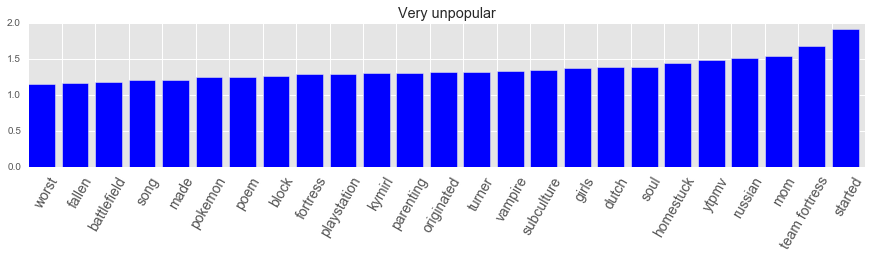

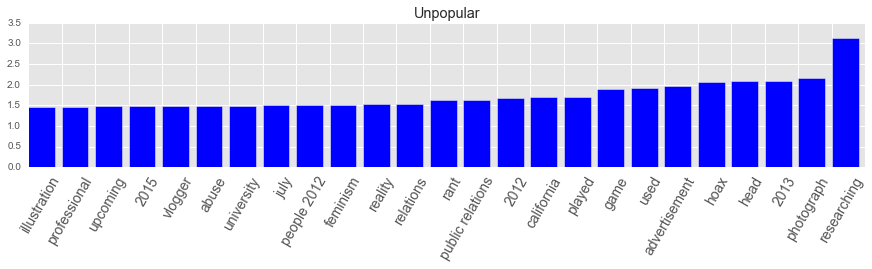

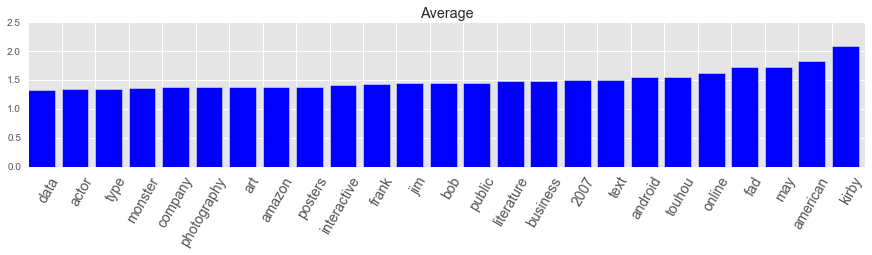

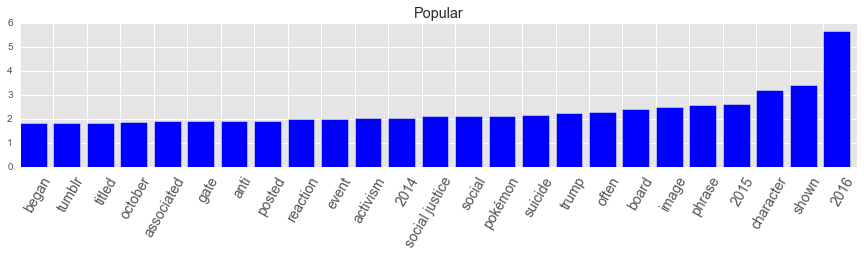

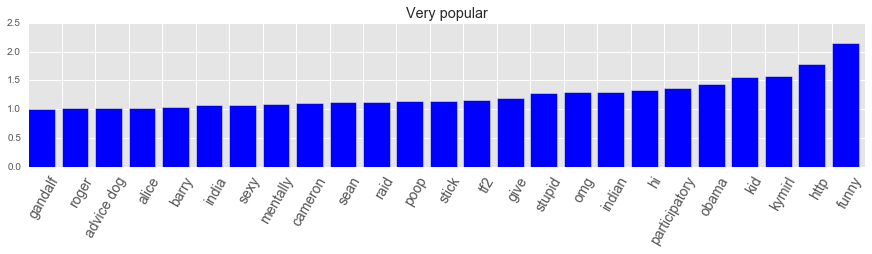

In [64]:
titles = ["Very unpopular", "Unpopular", 'Average', 'Popular', 'Very popular']
for i in range(5):
    visualize_coefficients(logit_sgd.coef_[i,:], tf_vectorizer.get_feature_names(),
                      title=titles[i], plot_num=i)

## Немного выводов

Получилось зянятно, самые популярные мемы содержали в своих описаниях слова funny, obama, islam, money, довольно логично - политика и посмеяться, вполне можно на таком популярность наращивать. 

На втором месте (категория Popular) снова есть политика, тут и trump, и politics, и activism. А еще сюда попал pokemon, главный тренд лета :)

В среднюю по популярности вошли немного животных - animal, pig, dogs, а также различные общие темы - health, literature, videogame, fashion, american football, то есть то, что сильного хайпа вызвать не может, но при этом всегда обсуждается

Непопулярными стали темы, связанные с researching, photograph, virtual, advertisment, professional и, как ни странно, сюда тоже попало слово politics, возможно, в этой группе оно встречалось не в контексте широко обсуждаемых политических тем, например, выборов в США

Наконец, самые позабытые мемы - когда-то популярный, но уже почти умерший team fortress, playstation, довольно много слов, связанных с национальностями, скучными оказались french, dutch, russian, также сюда снова попали покемоны, но написанные без фирменного знака ударения, скорее всего, это были мемы-подделки, которые особой популярности никогда не собирают

## Теперь подробнее посмотрим на лес

In [65]:
rf_params_dist_grid = {
    'max_depth': np.arange(5,14, 2),
    'max_features': np.linspace(0.2, 0.5, 3),
    'min_samples_leaf': np.arange(3,10,2)
}
rf_params_fixed = {
    'random_state': 7,
    'n_estimators': 100,
    'n_jobs': -1
    
}

![](https://pp.vk.me/c837129/v837129713/e948/2ruPyl7Dxj8.jpg)

In [66]:
combinations = np.prod([len(i) for i in rf_params_dist_grid.values()])
print('Total number of combinations: {}'.format(combinations))

Total number of combinations: 60


In [67]:
rf_grid = RandomizedSearchCV(
    estimator = RandomForestClassifier(**rf_params_fixed),
    param_distributions = rf_params_dist_grid,
    cv = skf,
    scoring='accuracy',
    n_iter = 10,
    verbose=True
)

In [68]:
%%time
rf_grid.fit(Xtr, ytr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.6min finished


CPU times: user 8min 33s, sys: 9.87 s, total: 8min 42s
Wall time: 4min 40s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=7,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_features': array([ 0.2 ,  0.35,  0.5 ]), 'max_depth': array([ 5,  7,  9, 11, 13]), 'min_samples_leaf': array([3, 5, 7, 9])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='accuracy', verbose=True)

In [69]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features=0.20000000000000001,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=9, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=7, verbose=0, warm_start=False)

In [70]:
def plot_with_std(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
        
def plot_learning_curve(clf, X, y, scoring, cv=5):
 
    train_sizes = np.linspace(0.05, 1, 20)
    n_train, val_train, val_test = learning_curve(clf,
                                                  X, y, train_sizes, cv=cv,
                                                  scoring=scoring, n_jobs = -1)
    plot_with_std(n_train, val_train, label='training scores', c='green')
    plot_with_std(n_train, val_test, label='validation scores', c='red')
    plt.xlabel('Training Set Size'); plt.ylabel(scoring)
    plt.legend()

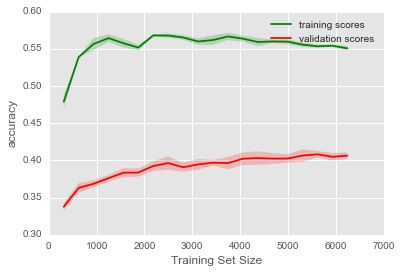

In [71]:
plot_learning_curve(rf_grid.best_estimator_,Xtr, ytr, scoring='accuracy', cv=5)

Уверенными шагами точность на валидации идет вверх

In [72]:
print('Accuracy: {}'.format(round(rf_grid.best_score_, 3)))

Accuracy: 0.408


Почти доросли по качеству до логита! Теперь обучимся на всх данных с подобранными параметрами

In [73]:
rfc = RandomForestClassifier(random_state=7, oob_score=True, n_estimators=100, n_jobs=-1, **rf_grid.best_params_)
rfc.fit(Xtr, ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features=0.20000000000000001,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=9, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=7, verbose=0, warm_start=False)

In [74]:
print('Accuracy: {}'.format(round(rfc.oob_score_, 3)))

Accuracy: 0.409


Точность осталась прежней и это хорошо. 

## Посмотрим на важность признаков

In [75]:
names = tf_vectorizer.get_feature_names()
importance = rfc.feature_importances_

feature_weights = pd.DataFrame(importance, index = names, columns = ['importance'])
feature_weights.sort_values(by=['importance'], ascending=False, inplace=True)

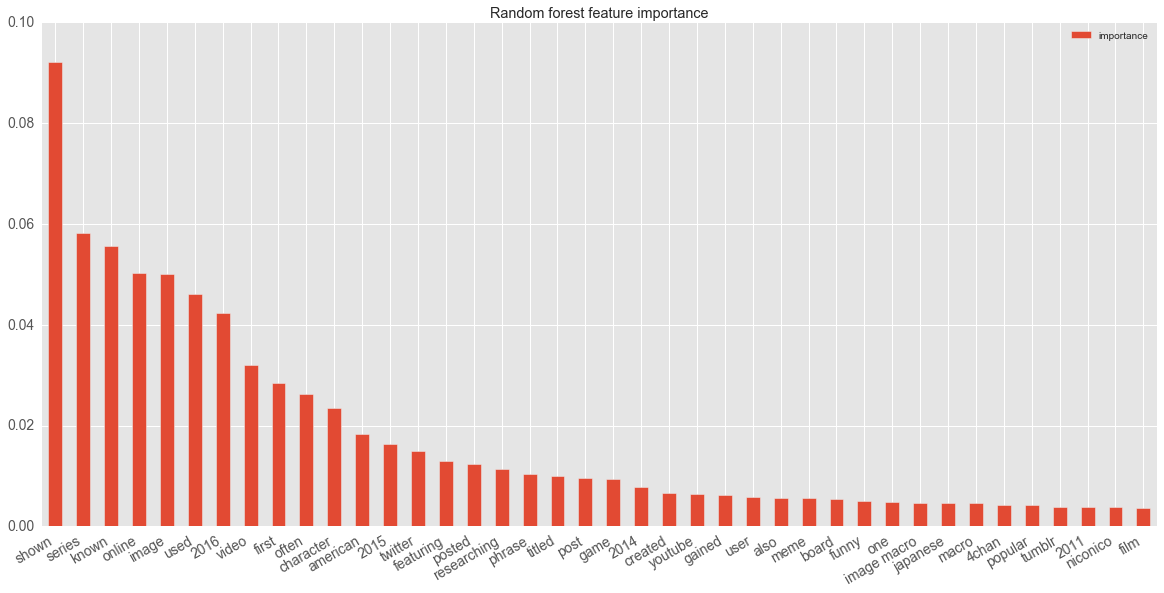

In [76]:
fig, ax = plt.subplots()
feature_weights.head(40).plot(ax=ax,kind = 'bar', figsize=(20, 10), fontsize=14)
fig.autofmt_xdate()
plt.title("Random forest feature importance");

По какой-то причине наиболее важным оказалось слово **shown**, без контекста сложно сказать, по какой причине; **series** скорее всего связано с различными мемами, произошедшими от сериалов; **image** и **video** также в топ-10, важно и наличие года в описании, в топ-40 есть годы с 2011 по 2016, скорее всего из-за связи со значимыми событиями этих лет. 

И, конечно, здесь представлены основные слова, которые выделяла логистическая регрессия - есть и politics, и funny, и meme, twitter и youtube и т.д. В чем-то модели друг с другом все-таки согласны

### А теперь можно взглянуть на confusion matrix и посмотреть, где же косячат модели

In [77]:
def plot_confusion(predictions, title):
    array = confusion_matrix(yval, predictions)
    df_cm = pd.DataFrame(array, index = [i for i in titles],
                      columns = [i for i in titles])
    plt.figure(figsize = (7,7))
    sn.heatmap(df_cm, annot=True, fmt='g', cbar=False)
    plt.title(title);

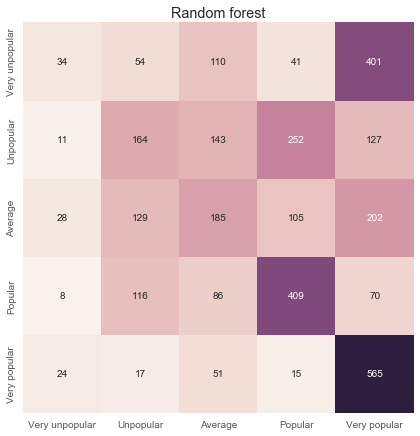

In [78]:
plot_confusion(map(np.argmax, rfc.predict_proba(Xval)), "Random forest")

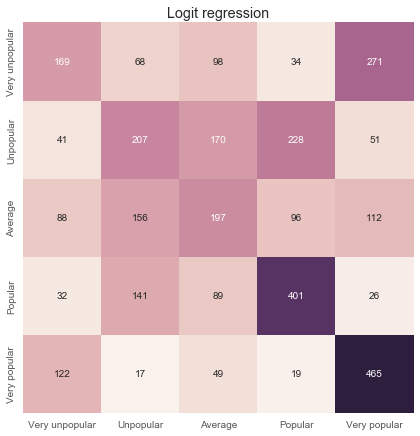

In [79]:
plot_confusion(map(np.argmax, logit_sgd.predict_proba(Xval)), "Logit regression")

Выходит, случайный лес лучше дифференцирует очень популярные и популярные мемы, а вот логит увереннее себя ведет на непопулярных и очень непопулярных картинках, имеет смысл смешать предсказания

In [80]:
def best_linear_mix(target, pred1, pred2):
    best_acc, best_w1 = 0, 0
    best_pred = pred1
    for w1 in np.linspace(0, 1, 100):
        curr_pred = w1 * pred1 + (1 - w1) * pred2
        curr_acc = accuracy_score(target, np.argmax(curr_pred, axis=1))
        if curr_acc >  best_acc:
            best_acc = curr_acc
            best_pred = curr_pred
            best_w1 = w1
    return best_acc, best_w1

In [81]:
mix_cv_acc, best_logit_weight = best_linear_mix(ytr, logit_sgd_oof_pred, rf_oof_pred)

In [82]:
print('Mix accuracy: {}'.format(round(mix_cv_acc, 3)))
print("Weight of logit in mix: {}".format(round(best_logit_weight, 3)))

Mix accuracy: 0.426
Weight of logit in mix: 0.939


А вот и прирост качества, точность повысилась на 2%, правда, лес в смесь вошел всего лишь на 8%. Посмотрим, что с качеством предсказаний

In [83]:
mix_valid_pred = best_logit_weight * logit_sgd_valid_pred + (1-best_logit_weight) * rfc.predict_proba(Xval)

In [84]:
print('Mix accuracy on validation: {}'.format(get_accuracy_score(mix_valid_pred, yval)))

Mix accuracy on validation: 0.429


Неплохо, теперь качество на трейне и тесте практически не отличается

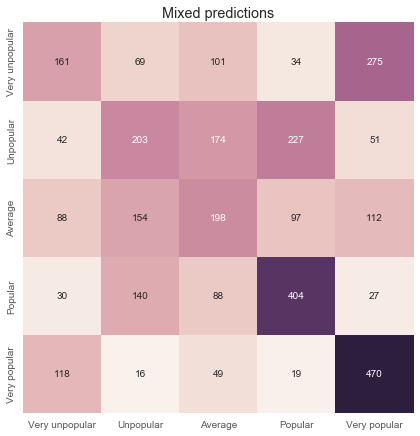

In [85]:
plot_confusion(map(np.argmax, mix_valid_pred), 'Mixed predictions')

Не то, чтобы сильно, но на диагонали стало чуть побольше верных значений, хотя по-прежнему идет сильное смешивание категорий very popular и very unpopular

# Выводы, немного размышлений и зачем вообщё это всё было

**Итого**:
1. Построены две модели, а также их смесь, которые дают точность предсказания популярности мема 0.43, что в 2.3 раза выше предсказания по константе
2. Наибольшее затруднение для моделей представляет дифференциация между Very Unpopular, Unpopular и Average группами. Возможно, это связано с характером данных, во время сбора часть мемов, которые только недавно были добавлены, получили не вполне честную оценку популярности (так как прошло слишком мало дней с момента их создания). Можно попробовать полечить отсечением выборки по времени, чтобы у каждого мема было, например, по месяцу истории.
3. По логистической модели получилось выделить некоторые логичные группы слов связной тематики, которые влияют на вероятность отнесения к классу

**Зачем это было сделано:**
1. For research purposes
2. Конечно, особо монетизировать предсказание популярности мема не выйдет, но вот предсказание виральности рекламного объявления - очень даже, так что бизнес-цели даже у такого проекта могут быть вполне серьезные

**Что можно сделать еще:**
1. Попробовать использовать более сложные модели, а лучше ансамбли моделей. Разреженный формат тектовых данных не позволил в данной работе объединить с собой очень много признаков, связанных с временем, также очень хорошо было бы включить различные метапризнаки, например, по тэгам можно разделить картинки на кластеры, в тексте описания также можно найти тэговые слова и относить по ним мемы к различным тематикам
2. Конечно, добавить нейросети. И много слоёв. Очень много. Датасет вполне можно дополнить самым основным, что даёт мем - непосредственно картинкой, а это открывает совершенно новые горизонты для исследования. К тому же бОльшая часть картинок создаётся по шаблонам (мемогенераторам), а это значит, можно выделять группы шаблонов по общим признакам на картинках и опять же использовать это для предсказания
3. Наконец, самое интересное - собственный мемогенератор, имея стандарты описаний, шаблонов, подписей на картинках и прочих вещей, можно попробовать синтезировать картинку с соответствующим ей описанием самостоятельно. Но LSTM, RNN и прочие радости пока впереди, так что продолжение проекта немного откладывается :) 



Ну и, по-традиции, 

**sorry for a long post, here is a potato for you**
![](http://www.cosplayisland.co.uk/files/costumes/855/41850/5643874030_530d7eba22.jpg)